In [1]:
import os
import pickle
import random as rn
import math 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.models import load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split 
from keras.layers.advanced_activations import LeakyReLU

pd.set_option('display.max_columns', 200)

print(tf.__version__)

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

2.5.0


In [2]:
def reset_seed(seed=0):
    os.environ['PYTHONHASHSEED'] = '0'
    rn.seed(seed) # fix random function seed
    np.random.seed(seed) # fix numpy seed
    tf.random.set_seed(seed) # fix tensorflow seed

In [3]:
def yyplot(y_true, y_pred):
    yvalues = np.concatenate([y_true.flatten(), y_pred.flatten()])
    ymin, ymax, yrange = np.amin(yvalues), np.amax(yvalues), np.ptp(yvalues)
    fig = plt.figure(figsize=(8, 8))
    plt.scatter(y_true, y_pred, s=1.0)
    plt.plot([ymin - yrange * 0.01, ymax + yrange * 0.01], [ymin - yrange * 0.01, ymax + yrange * 0.01], color="red", linestyle = "dashed")
    plt.xlim(ymin - yrange * 0.01, ymax + yrange * 0.01)
    plt.ylim(ymin - yrange * 0.01, ymax + yrange * 0.01)
    plt.xlabel('t: true value')
    plt.ylabel('y: predicted value')
    plt.title('True-Predicted Plot')
    plt.show()
    return fig

In [4]:
def metrics(y_true, y_pred):
    metrics = [r2_score(y_true=y_true, y_pred=y_pred), 
               np.sqrt(mean_squared_error(y_true=y_true, y_pred=y_pred)), 
               mean_absolute_error(y_true=y_true, y_pred=y_pred)
              ]
    return metrics

In [5]:
# Fix Random Seed
reset_seed(1234)

In [6]:
#Data Loading
import glob

folder_path="/content/drive/MyDrive/Colab Notebooks/CGH/AID2/Dataset"

all_files = glob.glob(folder_path+"/*.csv")
print(all_files)

list = []

for file_name in all_files:
    df_each = pd.read_csv(file_name)
    list.append(df_each)

df_raw = pd.concat(list, axis=0, ignore_index=True)
df_raw.head(10)

['/content/drive/MyDrive/Colab Notebooks/CGH/AID2/Dataset/conditions.csv']


,Unnamed: 0,FEED_N2,FEED_C1,FEED_C2,FEED_C3,FEED_iC4,FEED_nC4,FEED_C5+,AmbTemp,C3_CON_OUT,P_HPMR,P_LPMR,MCHE_BTM_DT,WB_UA,CB_UA,MR_N2,MR_C1,MR_C2,MR_C3,LMR_GASFLOW,FFF_Flow,SpecPower,ThermalEff,MCHE_OUT_T,MCHE_OUT_C_T,MCHE_MID_T,MCHE_MID_C_T,MCHE_IN_T,MCHE_IN_C_T,MR_GASFLOW,HMR_VFLOW,C3_GT_Power,LPMR_GT_Power,HPMR_GT_Power,LNG_Dens,Feasible,Note
0,1,1.0,92.8,3.5,1.8,0.45,0.45,0.0,35.0,59.2,60.0,1.82,2.0,1.546189e+07,8.318682e+05,6.0,39.2,41.4,13.4,82577.831748,-13720.876536,332.107788,0.865917,-144.45,-157.123012,-130.7,-134.387506,-29.057614,-30.418066,523547.289463,948.090364,32094.859507,31162.609095,28238.272503,431.668540,0,Less CB_UA
1,2,0.8,92.5,3.8,1.9,0.50,0.50,0.0,26.0,50.7,55.0,2.04,3.5,1.498481e+07,1.462980e+06,5.9,40.0,41.0,13.1,100573.850142,-19057.619215,304.504133,0.856291,-142.85,-155.746662,-123.7,-129.108945,-32.946088,-35.806928,518666.152335,916.788148,29456.397003,28645.389152,25121.595618,430.825451,1,NaN
2,3,0.7,92.6,3.9,1.8,0.50,0.50,0.0,29.0,51.2,51.5,2.12,4.0,1.307228e+07,1.985647e+06,7.0,38.6,42.2,12.2,138965.462506,-24098.821405,315.779516,0.839024,-140.25,-155.187382,-112.7,-120.806175,-32.719113,-36.075322,536581.043640,901.220792,30811.395298,29087.079884,24825.521479,426.368432,1,NaN
3,4,0.8,92.7,3.9,1.5,0.55,0.55,0.0,26.0,48.7,58.5,1.74,3.5,1.483471e+07,3.697995e+05,5.5,38.2,42.9,13.4,41882.520568,-29966.254445,296.544838,0.825383,-138.25,-155.813934,-130.7,-135.479967,-33.855187,-36.718666,467442.084959,910.984718,26848.362158,27574.401777,23759.817701,422.721526,0,Less CB_UA
4,5,0.9,92.3,3.7,1.7,0.70,0.70,0.0,21.5,43.2,56.0,1.94,7.0,1.488466e+07,1.240289e+06,6.4,40.2,40.7,12.7,85679.953279,-13896.706791,287.889113,0.875096,-145.65,-158.629441,-129.4,-133.401140,-36.335160,-42.696639,511696.263080,916.628985,27353.667120,28126.430499,24792.959363,436.953577,1,NaN
5,6,0.6,92.2,4.0,2.0,0.60,0.60,0.0,36.0,60.2,55.0,1.92,7.0,1.591572e+07,2.239318e+06,6.3,39.6,40.7,13.4,148565.215556,6407.334393,338.347548,0.905353,-153.05,-160.497889,-129.8,-132.226866,-28.596722,-34.949752,595508.378668,974.469311,35972.172431,33970.501378,29967.412069,447.747528,1,NaN
6,7,0.8,92.5,3.8,2.0,0.45,0.45,0.0,32.0,56.7,59.0,2.08,2.0,1.426342e+07,1.970134e+06,6.0,41.1,43.6,9.3,113778.987211,-1549.210283,332.547632,0.902009,-149.85,-158.048943,-132.6,-134.449316,-30.204236,-31.557764,571721.553878,967.574862,33227.998869,32052.997488,30373.196841,440.970136,1,NaN
7,8,0.8,92.5,3.4,2.0,0.65,0.65,0.0,21.0,45.7,52.0,1.72,2.5,1.548254e+07,1.868048e+06,7.0,39.7,41.3,12.0,135946.158671,3988.623707,297.080897,0.915010,-153.65,-162.755067,-129.5,-132.768155,-35.211522,-37.071076,553871.014653,907.167067,29672.986051,32987.392437,25108.163896,448.272238,1,NaN
8,9,0.6,92.0,3.9,2.0,0.75,0.75,0.0,24.0,49.2,58.5,2.02,2.0,1.569499e+07,2.249025e+06,6.6,41.8,40.2,11.4,110526.408165,2394.812727,303.435626,0.913290,-152.45,-160.745104,-134.2,-135.815741,-33.626440,-34.980192,552200.329598,935.096131,30122.311502,30923.827509,28226.952131,448.795859,1,NaN
9,10,0.9,92.0,3.8,1.8,0.75,0.75,0.0,27.5,49.7,50.0,2.16,5.5,1.484059e+07,2.214760e+06,6.7,42.8,42.5,8.0,228826.822707,10121.228974,333.409414,0.907636,-155.25,-160.261631,-137.6,-138.523893,-33.400016,-38.256917,653664.552452,898.797471,34708.107253,35119.992698,29631.659429,452.373362,1,NaN


In [7]:
# remove Note and Unnamed columns
df = df_raw.copy()
df.drop(["Note", "Unnamed: 0"], axis = 1, inplace = True)
df.head(10)

,FEED_N2,FEED_C1,FEED_C2,FEED_C3,FEED_iC4,FEED_nC4,FEED_C5+,AmbTemp,C3_CON_OUT,P_HPMR,P_LPMR,MCHE_BTM_DT,WB_UA,CB_UA,MR_N2,MR_C1,MR_C2,MR_C3,LMR_GASFLOW,FFF_Flow,SpecPower,ThermalEff,MCHE_OUT_T,MCHE_OUT_C_T,MCHE_MID_T,MCHE_MID_C_T,MCHE_IN_T,MCHE_IN_C_T,MR_GASFLOW,HMR_VFLOW,C3_GT_Power,LPMR_GT_Power,HPMR_GT_Power,LNG_Dens,Feasible
0,1.0,92.8,3.5,1.8,0.45,0.45,0.0,35.0,59.2,60.0,1.82,2.0,1.546189e+07,8.318682e+05,6.0,39.2,41.4,13.4,82577.831748,-13720.876536,332.107788,0.865917,-144.45,-157.123012,-130.7,-134.387506,-29.057614,-30.418066,523547.289463,948.090364,32094.859507,31162.609095,28238.272503,431.668540,0
1,0.8,92.5,3.8,1.9,0.50,0.50,0.0,26.0,50.7,55.0,2.04,3.5,1.498481e+07,1.462980e+06,5.9,40.0,41.0,13.1,100573.850142,-19057.619215,304.504133,0.856291,-142.85,-155.746662,-123.7,-129.108945,-32.946088,-35.806928,518666.152335,916.788148,29456.397003,28645.389152,25121.595618,430.825451,1
2,0.7,92.6,3.9,1.8,0.50,0.50,0.0,29.0,51.2,51.5,2.12,4.0,1.307228e+07,1.985647e+06,7.0,38.6,42.2,12.2,138965.462506,-24098.821405,315.779516,0.839024,-140.25,-155.187382,-112.7,-120.806175,-32.719113,-36.075322,536581.043640,901.220792,30811.395298,29087.079884,24825.521479,426.368432,1
3,0.8,92.7,3.9,1.5,0.55,0.55,0.0,26.0,48.7,58.5,1.74,3.5,1.483471e+07,3.697995e+05,5.5,38.2,42.9,13.4,41882.520568,-29966.254445,296.544838,0.825383,-138.25,-155.813934,-130.7,-135.479967,-33.855187,-36.718666,467442.084959,910.984718,26848.362158,27574.401777,23759.817701,422.721526,0
4,0.9,92.3,3.7,1.7,0.70,0.70,0.0,21.5,43.2,56.0,1.94,7.0,1.488466e+07,1.240289e+06,6.4,40.2,40.7,12.7,85679.953279,-13896.706791,287.889113,0.875096,-145.65,-158.629441,-129.4,-133.401140,-36.335160,-42.696639,511696.263080,916.628985,27353.667120,28126.430499,24792.959363,436.953577,1
5,0.6,92.2,4.0,2.0,0.60,0.60,0.0,36.0,60.2,55.0,1.92,7.0,1.591572e+07,2.239318e+06,6.3,39.6,40.7,13.4,148565.215556,6407.334393,338.347548,0.905353,-153.05,-160.497889,-129.8,-132.226866,-28.596722,-34.949752,595508.378668,974.469311,35972.172431,33970.501378,29967.412069,447.747528,1
6,0.8,92.5,3.8,2.0,0.45,0.45,0.0,32.0,56.7,59.0,2.08,2.0,1.426342e+07,1.970134e+06,6.0,41.1,43.6,9.3,113778.987211,-1549.210283,332.547632,0.902009,-149.85,-158.048943,-132.6,-134.449316,-30.204236,-31.557764,571721.553878,967.574862,33227.998869,32052.997488,30373.196841,440.970136,1
7,0.8,92.5,3.4,2.0,0.65,0.65,0.0,21.0,45.7,52.0,1.72,2.5,1.548254e+07,1.868048e+06,7.0,39.7,41.3,12.0,135946.158671,3988.623707,297.080897,0.915010,-153.65,-162.755067,-129.5,-132.768155,-35.211522,-37.071076,553871.014653,907.167067,29672.986051,32987.392437,25108.163896,448.272238,1
8,0.6,92.0,3.9,2.0,0.75,0.75,0.0,24.0,49.2,58.5,2.02,2.0,1.569499e+07,2.249025e+06,6.6,41.8,40.2,11.4,110526.408165,2394.812727,303.435626,0.913290,-152.45,-160.745104,-134.2,-135.815741,-33.626440,-34.980192,552200.329598,935.096131,30122.311502,30923.827509,28226.952131,448.795859,1
9,0.9,92.0,3.8,1.8,0.75,0.75,0.0,27.5,49.7,50.0,2.16,5.5,1.484059e+07,2.214760e+06,6.7,42.8,42.5,8.0,228826.822707,10121.228974,333.409414,0.907636,-155.25,-160.261631,-137.6,-138.523893,-33.400016,-38.256917,653664.552452,898.797471,34708.107253,35119.992698,29631.659429,452.373362,1


12


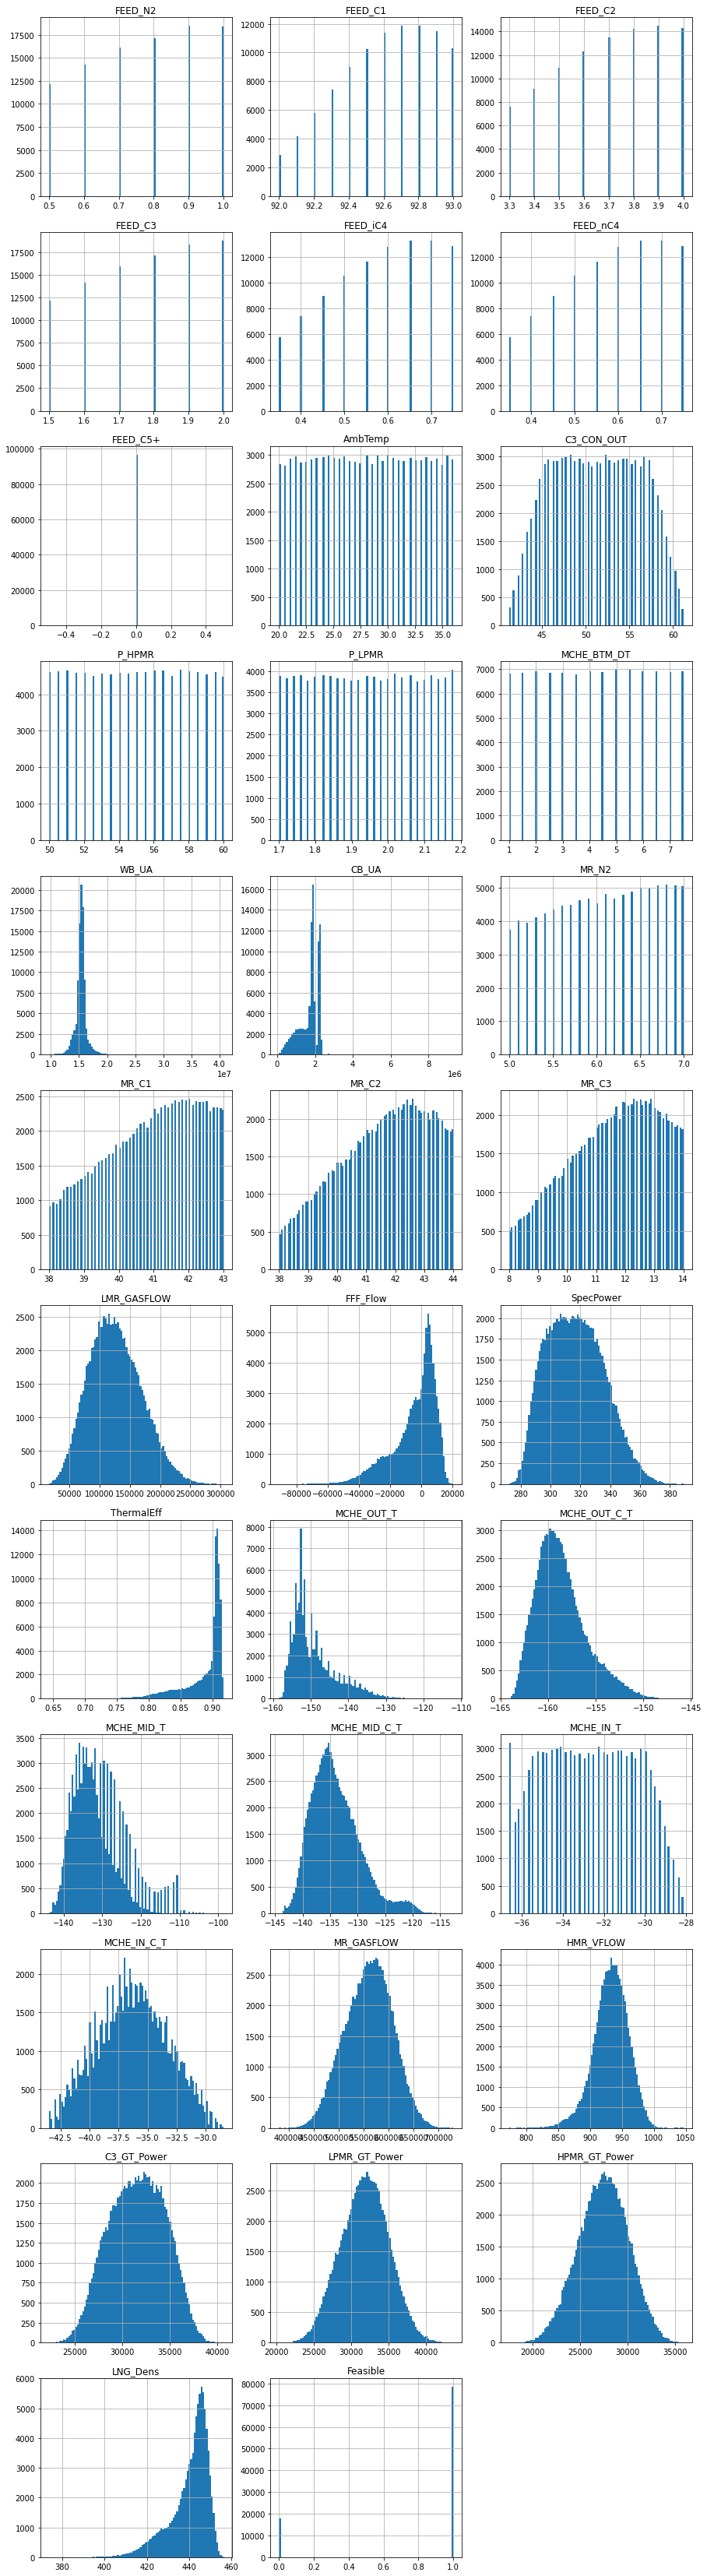

In [8]:
# Visuallization of each tag
#to be updated# 
num_row = math.ceil(len(df.columns) / 3)
print(num_row)

plt.figure(figsize=(15, 5 * num_row))
i=0

for tag in df.columns:
    i += 1
     
    plt.subplot(num_row, 3, i)
    x1=df[tag]
    plt.hist(x=x1, bins=100)
    plt.grid()
    plt.title(label=tag)
    
plt.show()

In [9]:
# Pretreatment of Dataset
#to be updated# 
df = df[df['Feasible'] != 0]
df.head(10)

,FEED_N2,FEED_C1,FEED_C2,FEED_C3,FEED_iC4,FEED_nC4,FEED_C5+,AmbTemp,C3_CON_OUT,P_HPMR,P_LPMR,MCHE_BTM_DT,WB_UA,CB_UA,MR_N2,MR_C1,MR_C2,MR_C3,LMR_GASFLOW,FFF_Flow,SpecPower,ThermalEff,MCHE_OUT_T,MCHE_OUT_C_T,MCHE_MID_T,MCHE_MID_C_T,MCHE_IN_T,MCHE_IN_C_T,MR_GASFLOW,HMR_VFLOW,C3_GT_Power,LPMR_GT_Power,HPMR_GT_Power,LNG_Dens,Feasible
1,0.8,92.5,3.8,1.9,0.50,0.50,0.0,26.0,50.7,55.0,2.04,3.5,1.498481e+07,1.462980e+06,5.9,40.0,41.0,13.1,100573.850142,-19057.619215,304.504133,0.856291,-142.85,-155.746662,-123.7,-129.108945,-32.946088,-35.806928,518666.152335,916.788148,29456.397003,28645.389152,25121.595618,430.825451,1
2,0.7,92.6,3.9,1.8,0.50,0.50,0.0,29.0,51.2,51.5,2.12,4.0,1.307228e+07,1.985647e+06,7.0,38.6,42.2,12.2,138965.462506,-24098.821405,315.779516,0.839024,-140.25,-155.187382,-112.7,-120.806175,-32.719113,-36.075322,536581.043640,901.220792,30811.395298,29087.079884,24825.521479,426.368432,1
4,0.9,92.3,3.7,1.7,0.70,0.70,0.0,21.5,43.2,56.0,1.94,7.0,1.488466e+07,1.240289e+06,6.4,40.2,40.7,12.7,85679.953279,-13896.706791,287.889113,0.875096,-145.65,-158.629441,-129.4,-133.401140,-36.335160,-42.696639,511696.263080,916.628985,27353.667120,28126.430499,24792.959363,436.953577,1
5,0.6,92.2,4.0,2.0,0.60,0.60,0.0,36.0,60.2,55.0,1.92,7.0,1.591572e+07,2.239318e+06,6.3,39.6,40.7,13.4,148565.215556,6407.334393,338.347548,0.905353,-153.05,-160.497889,-129.8,-132.226866,-28.596722,-34.949752,595508.378668,974.469311,35972.172431,33970.501378,29967.412069,447.747528,1
6,0.8,92.5,3.8,2.0,0.45,0.45,0.0,32.0,56.7,59.0,2.08,2.0,1.426342e+07,1.970134e+06,6.0,41.1,43.6,9.3,113778.987211,-1549.210283,332.547632,0.902009,-149.85,-158.048943,-132.6,-134.449316,-30.204236,-31.557764,571721.553878,967.574862,33227.998869,32052.997488,30373.196841,440.970136,1
7,0.8,92.5,3.4,2.0,0.65,0.65,0.0,21.0,45.7,52.0,1.72,2.5,1.548254e+07,1.868048e+06,7.0,39.7,41.3,12.0,135946.158671,3988.623707,297.080897,0.915010,-153.65,-162.755067,-129.5,-132.768155,-35.211522,-37.071076,553871.014653,907.167067,29672.986051,32987.392437,25108.163896,448.272238,1
8,0.6,92.0,3.9,2.0,0.75,0.75,0.0,24.0,49.2,58.5,2.02,2.0,1.569499e+07,2.249025e+06,6.6,41.8,40.2,11.4,110526.408165,2394.812727,303.435626,0.913290,-152.45,-160.745104,-134.2,-135.815741,-33.626440,-34.980192,552200.329598,935.096131,30122.311502,30923.827509,28226.952131,448.795859,1
9,0.9,92.0,3.8,1.8,0.75,0.75,0.0,27.5,49.7,50.0,2.16,5.5,1.484059e+07,2.214760e+06,6.7,42.8,42.5,8.0,228826.822707,10121.228974,333.409414,0.907636,-155.25,-160.261631,-137.6,-138.523893,-33.400016,-38.256917,653664.552452,898.797471,34708.107253,35119.992698,29631.659429,452.373362,1
10,0.5,92.9,3.7,1.5,0.70,0.70,0.0,31.0,52.7,56.0,1.76,5.5,1.537462e+07,1.893312e+06,6.0,40.7,40.0,13.3,115598.046459,2029.034401,318.002330,0.909666,-151.85,-160.460083,-131.9,-134.338990,-32.036013,-36.894984,560040.357810,957.002424,32088.998531,32976.488093,28133.067154,443.877622,1
11,0.9,92.7,3.4,1.6,0.70,0.70,0.0,24.0,47.7,59.0,1.94,3.0,1.540220e+07,1.277334e+06,6.3,40.0,43.9,9.8,73957.121239,-8318.717847,301.669902,0.888834,-147.85,-159.215840,-135.9,-137.607757,-34.308054,-36.669280,523023.591321,939.605641,28895.812033,29622.926594,26890.981324,438.867762,1


In [10]:
# Scaler
sc_x = StandardScaler()
sc_y = StandardScaler()

In [11]:
#To be updated according to the Specification#

# explanatory variable - given
list_u = [
    'FEED_N2',
    'FEED_C1',
    'FEED_C2',
    'FEED_C3',
#     'FEED_iC4',
#     'FEED_nC4',
#     'FEED_C5+',
    'AmbTemp',
    'C3_CON_OUT',
#     'MCHE_IN_T',
    'WB_UA',
    'CB_UA'
]

# explanatory variable - search
list_v = [
    'P_HPMR',
    'P_LPMR',
    'MCHE_BTM_DT',
#     'MR_N2',
    'MR_C1',
    'MR_C2',
    'MR_C3'
]

list_x = list_u + list_v

In [12]:
df_x = df.loc[:, list_x]
df_x.describe()

,FEED_N2,FEED_C1,FEED_C2,FEED_C3,AmbTemp,C3_CON_OUT,WB_UA,CB_UA,P_HPMR,P_LPMR,MCHE_BTM_DT,MR_C1,MR_C2,MR_C3
count,78492.000000,78492.000000,78492.000000,78492.000000,78492.000000,78492.000000,7.849200e+04,7.849200e+04,78492.000000,78492.000000,78492.000000,78492.000000,78492.000000,78492.000000
mean,0.772967,92.597098,3.694397,1.775303,28.561713,51.796812,1.544166e+07,1.902363e+06,54.578231,1.935224,4.310382,41.152441,41.444184,11.298211
std,0.166580,0.277516,0.218594,0.166677,4.682627,4.836847,9.387198e+05,3.000158e+05,2.967038,0.144139,2.010944,1.249483,1.597669,1.545636
min,0.500000,92.000000,3.300000,1.500000,20.000000,41.200000,1.147112e+07,9.885195e+05,50.000000,1.700000,1.000000,38.000000,38.000000,8.000000
25%,0.600000,92.400000,3.500000,1.600000,24.500000,47.700000,1.502264e+07,1.774307e+06,52.000000,1.820000,2.500000,40.300000,40.200000,10.100000
50%,0.800000,92.600000,3.700000,1.800000,29.000000,52.200000,1.546086e+07,1.894295e+06,54.500000,1.940000,4.500000,41.300000,41.600000,11.400000
75%,0.900000,92.800000,3.900000,1.900000,32.500000,55.700000,1.583172e+07,2.196960e+06,57.000000,2.060000,6.000000,42.200000,42.800000,12.500000
max,1.000000,93.000000,4.000000,2.000000,36.000000,61.200000,2.128458e+07,2.946253e+06,60.000000,2.180000,7.500000,43.000000,44.000000,14.000000


In [13]:
df_y = df.loc[:, ['SpecPower']]
df_y.describe()

,SpecPower
count,78492.000000
mean,320.490911
std,17.875592
min,277.350263
25%,306.648624
50%,319.993507
75%,333.151365
max,388.964464


In [14]:
x = df_x.values
y = df_y.values

In [15]:
x_scaled = sc_x.fit_transform(x)
y_scaled = sc_y.fit_transform(y)

In [16]:
# Save Scaler File
from pickle import dump
dump(sc_x, open('/content/drive/MyDrive/Colab Notebooks/CGH/AID2/Step1_Regression/SpecPower/Output/SpecPower_sc_x.pkl', 'wb'))
dump(sc_y, open('/content/drive/MyDrive/Colab Notebooks/CGH/AID2/Step1_Regression/SpecPower/Output/SpecPower_sc_y.pkl', 'wb'))

In [27]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y_scaled, test_size=0.1, random_state=0,shuffle=False)

In [28]:
# Define Model
input_dim = x_train.shape[1]
output_dim = y_train.shape[1]

model = Sequential()
model.add(Dense(units=25, input_dim=input_dim, activation='tanh'))
model.add(Dense(units=10, activation='tanh'))
# model.add(Dense(units=5, activation='tanh'))
# model.add(Dense(units=10, activation='tanh'))
model.add(Dense(units=output_dim))
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='mean_squared_error')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 25)                375       
_________________________________________________________________
dense_4 (Dense)              (None, 10)                260       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 11        
Total params: 646
Trainable params: 646
Non-trainable params: 0
_________________________________________________________________


In [29]:
import datetime
x = datetime.datetime.now()

model_path_out = '/content/drive/MyDrive/Colab Notebooks/CGH/AID2/Step1_Regression/SpecPower/Output/SpecPower{}.h5'.format(x.day)
mc = ModelCheckpoint(filepath=model_path_out, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [30]:
%%time
history = model.fit(x=x_train, y=y_train, batch_size=128, epochs=1000, verbose=1, callbacks=[mc], validation_data=(x_test, y_test))

Epoch 1/1000
552/552 [==============================] - 2s 2ms/step - loss: 0.3569 - val_loss: 0.0244

Epoch 00001: val_loss improved from inf to 0.02444, saving model to /content/drive/MyDrive/Colab Notebooks/CGH/AID2/Step1_Regression/SpecPower/Output/SpecPower24.h5
Epoch 2/1000
552/552 [==============================] - 1s 2ms/step - loss: 0.0212 - val_loss: 0.0122

Epoch 00002: val_loss improved from 0.02444 to 0.01225, saving model to /content/drive/MyDrive/Colab Notebooks/CGH/AID2/Step1_Regression/SpecPower/Output/SpecPower24.h5
Epoch 3/1000
552/552 [==============================] - 1s 2ms/step - loss: 0.0110 - val_loss: 0.0075

Epoch 00003: val_loss improved from 0.01225 to 0.00748, saving model to /content/drive/MyDrive/Colab Notebooks/CGH/AID2/Step1_Regression/SpecPower/Output/SpecPower24.h5
Epoch 4/1000
552/552 [==============================] - 1s 2ms/step - loss: 0.0068 - val_loss: 0.0048

Epoch 00004: val_loss improved from 0.00748 to 0.00477, saving model to /content/driv

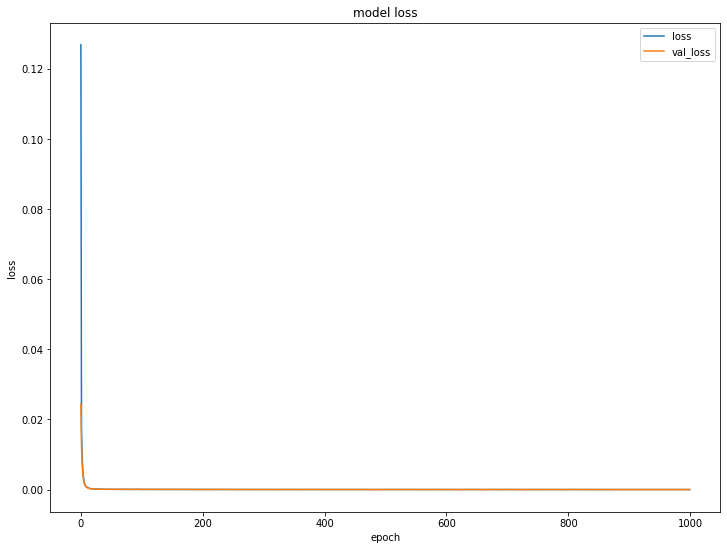

In [31]:
# Show Learning Curve
fig = plt.figure(figsize=(12, 9))
plt.plot(history.history['loss'],"-",label="loss",)
plt.plot(history.history['val_loss'],"-",label="val_loss")
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='best')
plt.show()

In [32]:
model_best = load_model(model_path_out)

In [33]:
y_pred = model_best.predict(x_test)
y_pred_inv = sc_y.inverse_transform(y_pred)
y_test_inv = sc_y.inverse_transform(y_test)

In [34]:
# 予測精度の評価
mtrc = metrics(y_true=y_test_inv, y_pred=y_pred_inv)
print("r2       : %.4f" % mtrc[0])
print("rmse     : %.4f" % mtrc[1])
print("rmse/avg.: %.6f" % (mtrc[1] / abs(y_test_inv.mean())))
print("mae      : %.4f" % mtrc[2])
print("mae/avg. : %.6f" % (mtrc[2] / abs(y_test_inv.mean())))

r2       : 1.0000
rmse     : 0.0631
rmse/avg.: 0.000197
mae      : 0.0453
mae/avg. : 0.000142


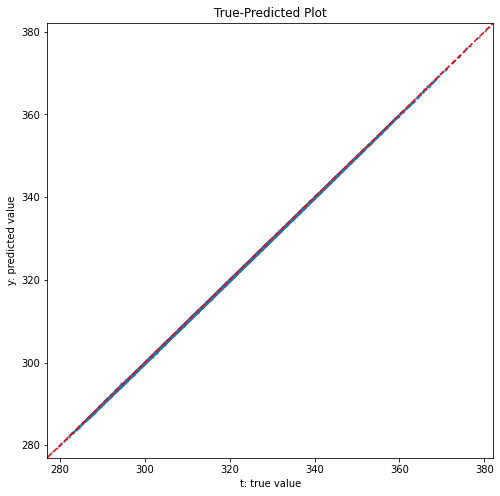

In [25]:
fig = yyplot(y_true=y_test_inv, y_pred=y_pred_inv)

In [26]:
# Scaler Information for Javascript
# label
print("Scaler Information")

list_sc_x = []
for i in df_x.describe():
    list_sc_x.append(i)
print("\n    // Input_Values", list_sc_x)
print("    X:{")

# mean
list_sc_x = []
for i in df_x.mean():
    list_sc_x.append(round(i,6))
print("        mean:", list_sc_x, ",")

# std
list_sc_x = []
for i in df_x.std():
    list_sc_x.append(round(i,6))
print("        std:", list_sc_x, ",")

# max
list_sc_x = []
for i in df_x.max():
    list_sc_x.append(round(i,6))
print("        max:", list_sc_x, ",")

# min
list_sc_x = []
for i in df_x.min():
    list_sc_x.append(round(i,6))
print("        min:", list_sc_x, ",")

print("    },")


# label
list_sc_y = []
for i in df_y.describe():
    list_sc_y.append(i)
print("\n    // Output_Values", list_sc_y)
print("    Y:{")

# mean
list_sc_y = []
for i in df_y.mean():
    list_sc_y.append(round(i,6))
print("        mean:", list_sc_y, ",")

# std
list_sc_y = []
for i in df_y.std():
    list_sc_y.append(round(i,6))
print("        std:", list_sc_y, ",")
print("    },")

Scaler Information

    // Input_Values ['FEED_N2', 'FEED_C1', 'FEED_C2', 'FEED_C3', 'AmbTemp', 'C3_CON_OUT', 'WB_UA', 'CB_UA', 'P_HPMR', 'P_LPMR', 'MCHE_BTM_DT', 'MR_C1', 'MR_C2', 'MR_C3']
    X:{
        mean: [0.772967, 92.597098, 3.694397, 1.775303, 28.561713, 51.796812, 15441661.652489, 1902362.778909, 54.578231, 1.935224, 4.310382, 41.152441, 41.444184, 11.298211] ,
        std: [0.16658, 0.277516, 0.218594, 0.166677, 4.682627, 4.836847, 938719.834331, 300015.829377, 2.967038, 0.144139, 2.010944, 1.249483, 1.597669, 1.545636] ,
        max: [1.0, 93.0, 4.0, 2.0, 36.0, 61.2, 21284579.062142, 2946252.81551, 60.0, 2.18, 7.5, 43.0, 44.0, 14.0] ,
        min: [0.5, 92.0, 3.3, 1.5, 20.0, 41.2, 11471119.91742, 988519.524345, 50.0, 1.7, 1.0, 38.0, 38.0, 8.0] ,
    },

    // Output_Values ['SpecPower']
    Y:{
        mean: [320.490911] ,
        std: [17.875592] ,
    },
